## Marie 2020 -Testing asymmetries

Intensifying phase: Dorian 2019, Lester 2016, Sam 2021 (no MAXSS on this one)

Stationary phase: Hector 2018

Weakening phase: Marie 2020

In [1]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit

# Custom
import functions as f
import dataUtils as du

# Statistics
from sklearn import linear_model, neighbors
from pykalman import KalmanFilter

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
PATHS = {
    'ds_glob_path':    '/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_13052022_with_extra_params.nc',
    'sar_dir':         '/home/arthur/data/cyclobs/centered_rotated_files_31012022/',
    'rad_dir':         '/home/arthur/data/radiometer/KNMI/product_JF_rotated_filtered/POLAR/2020/EP182020/',
}

### 1) SAR

In [3]:
### OPEN DATA
dsg = xr.open_dataset(PATHS['ds_glob_path'])

/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/lib-dynload/../../libffi.so.8: version `LIBFFI_CLOSURE_7.0' not found (required by /home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/_cffi_backend.cpython-38-x86_64-linux-gnu.so)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [4]:
dm  = dsg.where(dsg.storm_name == 'MARIE', drop=True)

Text(0.5, 1.0, 'MARIE, EP182020')

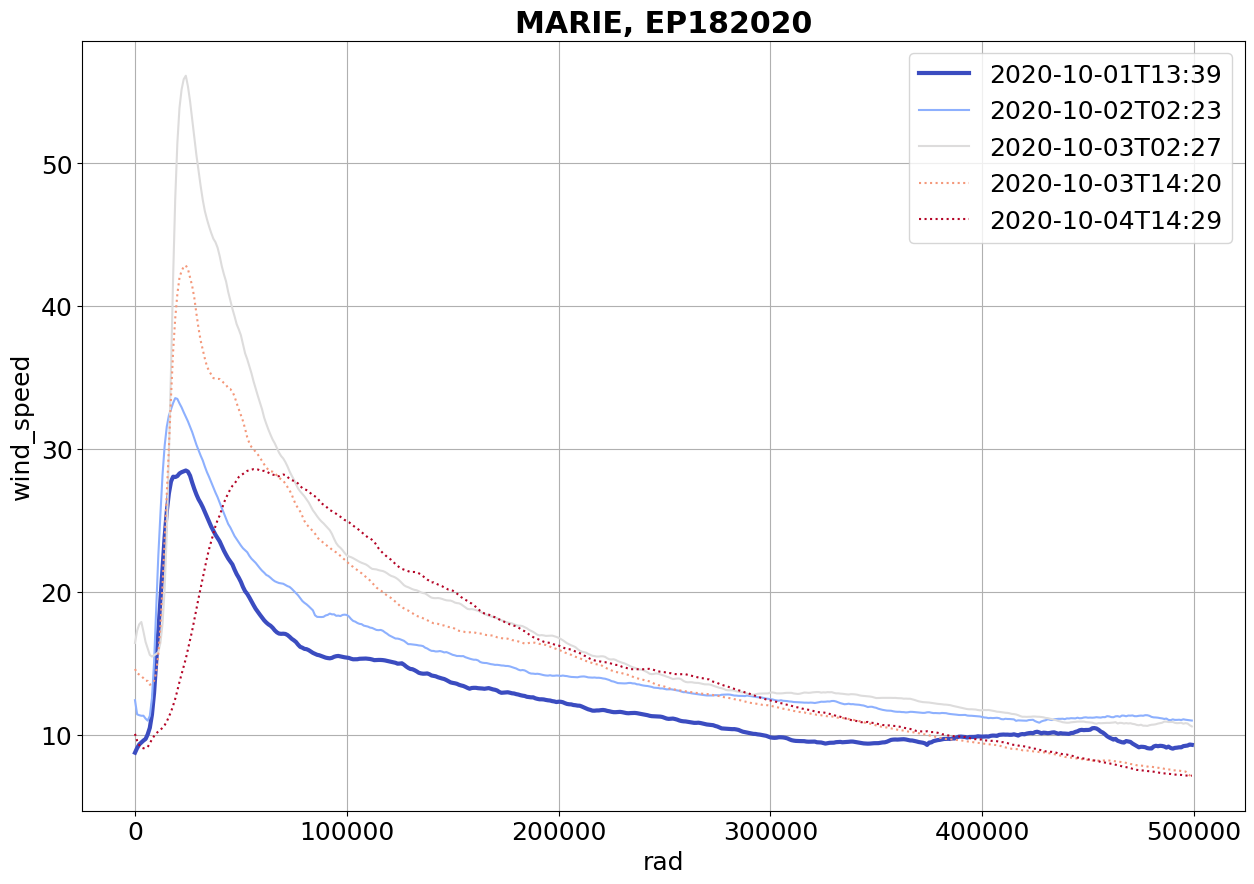

In [5]:
### MARIE
p1 = 'rs2--owi-ca-20201001t133839-20201001t133955-00003-3268A_sw_ep182020_cyclone.nc'
p2 = 'rs2--owi-ca-20201002t022254-20201002t022409-00003-3268A_sw_ep182020_cyclone.nc'
p3 = 's1a-ew-owi-ca-20201003t022600-20201003t022817-000003-04082E_sw_ep182020_cyclone.nc'
p4 = 'rs2--owi-ca-20201003t141913-20201003t142136-00003-3268A_sw_ep182020_cyclone.nc'
p5 = 's1b-ew-owi-ca-20201004t142803-20201004t143007-000003-02CF68_sw_ep182020_cyclone.nc'

colors = mpl.cm.coolwarm(np.linspace(0, 1, 5))

ds1 = xr.open_dataset(PATHS['sar_dir'] + p1).isel(time=0)
ds2 = xr.open_dataset(PATHS['sar_dir'] + p2).isel(time=0)
ds3 = xr.open_dataset(PATHS['sar_dir'] + p3).isel(time=0)
ds4 = xr.open_dataset(PATHS['sar_dir'] + p4).isel(time=0)
ds5 = xr.open_dataset(PATHS['sar_dir'] + p5).isel(time=0)

ws1 = ds1.wind_speed.mean(dim='theta', skipna=True)
ws2 = ds2.wind_speed.mean(dim='theta', skipna=True)
ws3 = ds3.wind_speed.mean(dim='theta', skipna=True)
ws4 = ds4.wind_speed.mean(dim='theta', skipna=True)
ws5 = ds5.wind_speed.mean(dim='theta', skipna=True)

ws1.plot(label='{}'.format(np.datetime_as_string(ds1.time, unit='m')), c=colors[0], linewidth=3)
ws2.plot(label='{}'.format(np.datetime_as_string(ds2.time, unit='m')), c=colors[1])
ws3.plot(label='{}'.format(np.datetime_as_string(ds3.time, unit='m')), c=colors[2])
ws4.plot(label='{}'.format(np.datetime_as_string(ds4.time, unit='m')), c=colors[3], linestyle='dotted')
ws5.plot(label='{}'.format(np.datetime_as_string(ds5.time, unit='m')), c=colors[4], linestyle='dotted')
plt.grid();plt.legend();plt.title('MARIE, EP182020', weight='bold')

# 36hrs between both images

In [6]:
dm = dm.sortby('time')
for t in range(len(dm.time)):
    print(dm.isel(time=t).sat_file.item(), '      B = {:.1f}'.format(dm.isel(time=t).B_hol))

rs2--owi-cm-20201001t133839-20201001t133955-00003-3268A_sw.nc       B = 1.9
rs2--owi-cm-20201002t022254-20201002t022409-00003-3268A_sw.nc       B = 1.9
s1a-ew-owi-cm-20201003t022600-20201003t022817-000003-04082E_sw.nc       B = 2.5
rs2--owi-cm-20201003t141913-20201003t142136-00003-3268A_sw.nc       B = 1.8
s1b-ew-owi-cm-20201004t142803-20201004t143007-000003-02CF68_sw.nc       B = 2.0


In [7]:
### FUNCTIONS
def pth2dtt(p):
    d = xr.open_dataset(p)
    return d.acquisition_time.data

def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                            # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at 20° latitude and assuming it's constant 
    return fcor

In [8]:
### OPEN DATA
all_rad = glob.glob(PATHS['rad_dir'] + '*.nc')
print('nb of scat files = ', len(all_rad))

# Sort all files
all_rad = sorted(all_rad, key=pth2dtt)

nb of scat files =  25


Text(0.5, 0, 'r (km)')

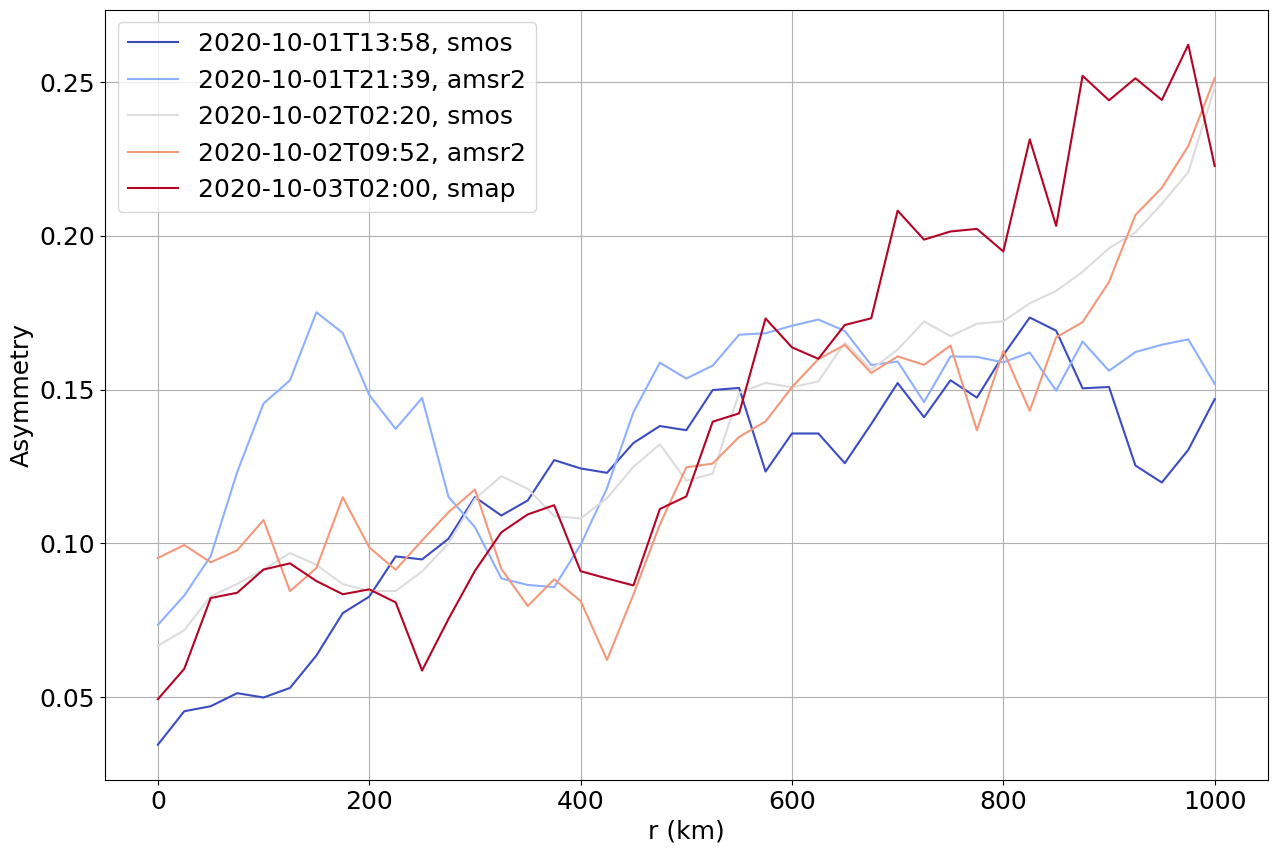

In [14]:
# k_stt, k_end = 10, 20
k_stt, k_end = 11, 15
colors = mpl.cm.coolwarm(np.linspace(0, 1, k_end - k_stt + 1))
for k in range(k_stt, k_end + 1):
    d            = xr.open_dataset(all_rad[k])
    std_prof_rad = (d.wind_speed / d.wind_speed.max(dim=['theta'])).std(dim='theta', skipna=True)
    plt.plot(std_prof_rad.rad, std_prof_rad, label='{}, {}'.format(np.datetime_as_string(d.acquisition_time, unit='m'), d.mission.item()), c=colors[k - k_stt])
plt.grid();plt.legend()
plt.ylabel('Asymmetry');plt.xlabel('r (km)')

Text(0.5, 0, 'r (km)')

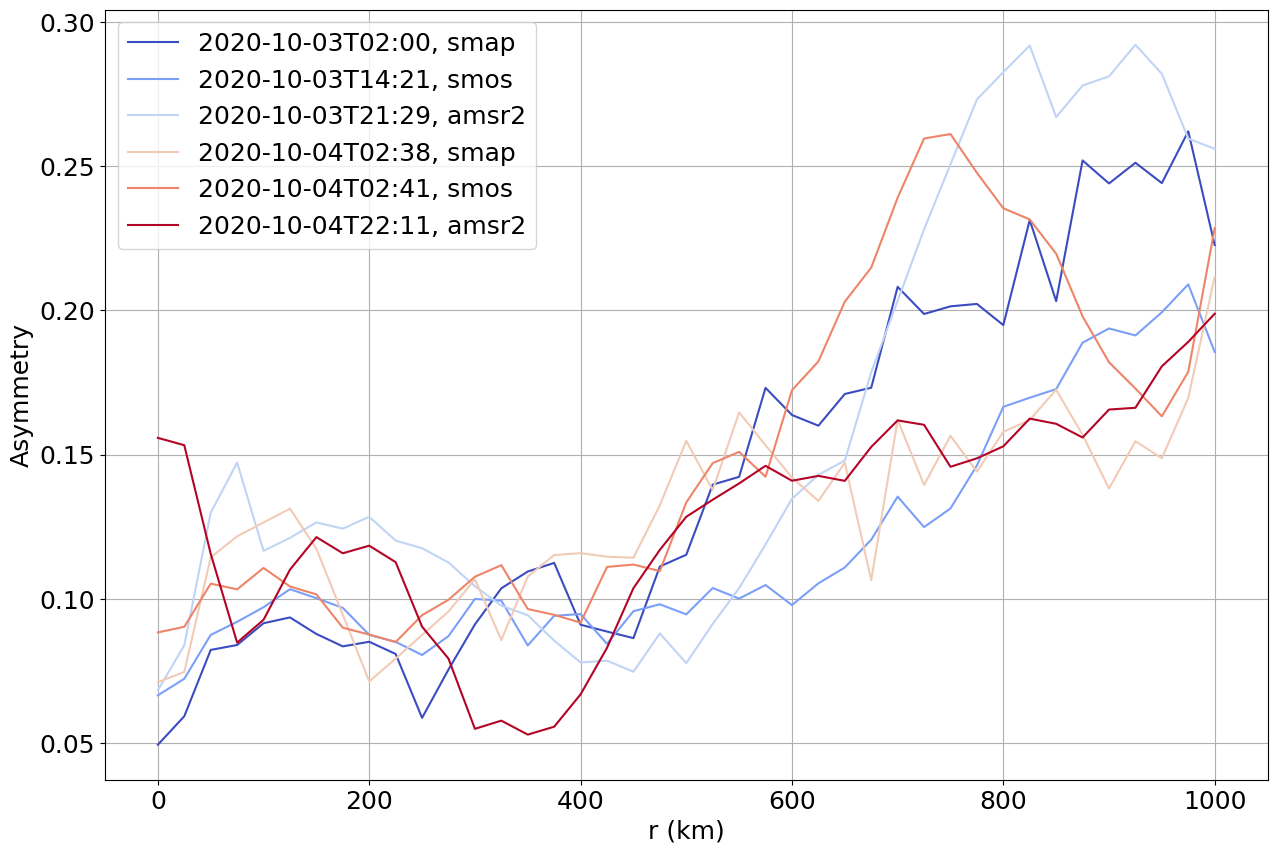

In [17]:
# k_stt, k_end = 10, 20
k_stt, k_end = 15, 20
colors = mpl.cm.coolwarm(np.linspace(0, 1, k_end - k_stt + 1))
for k in range(k_stt, k_end + 1):
    d            = xr.open_dataset(all_rad[k])
    std_prof_rad = (d.wind_speed / d.wind_speed.max(dim=['theta'])).std(dim='theta', skipna=True)
    plt.plot(std_prof_rad.rad, std_prof_rad, label='{}, {}'.format(np.datetime_as_string(d.acquisition_time, unit='m'), d.mission.item()), c=colors[k - k_stt])
plt.grid();plt.legend()
plt.ylabel('Asymmetry');plt.xlabel('r (km)')